In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
import pydot
import sys

In [38]:
import warnings
warnings.filterwarnings('always')

In [39]:
sys.path.insert(0, '..')
from data_wrangling import create_new_folder
from modeling_results import pred_results, plot_confusion_matrix
from cnn_model import *
from resnet50 import *

In [40]:
#generate a dataset
train = r'../train_images'
val = r'../val_images'

In [41]:
image_size = (200, 200) #(height, width)
batch_size = 32
num_classes = len(os.listdir(train))

train_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.1,
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='reflect'
                              )
val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(directory=train, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              seed=42)

validation_generator = val_gen.flow_from_directory(directory=val, 
                                                   target_size=image_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical', 
                                                   batch_size = 1,
                                                   seed=42)

Found 1903 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


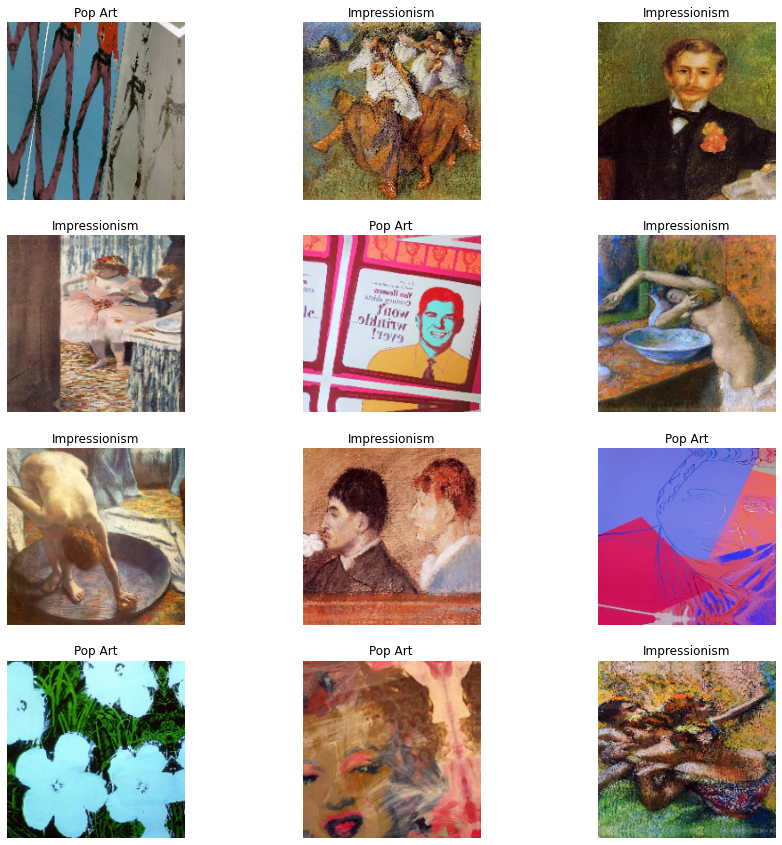

In [42]:
plt.figure(figsize=(15,15))

x, y = train_generator.__getitem__(10) #returns batch of size 32; arg is a random sequence of the batch
x = x.reshape((1,)+x.shape)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y = [np.argmax(i) for i in y]
y = [labels[k] for k in y]

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")

In [43]:
modelpath = r'../models/model'
epochs = 25

# CNN MODEL

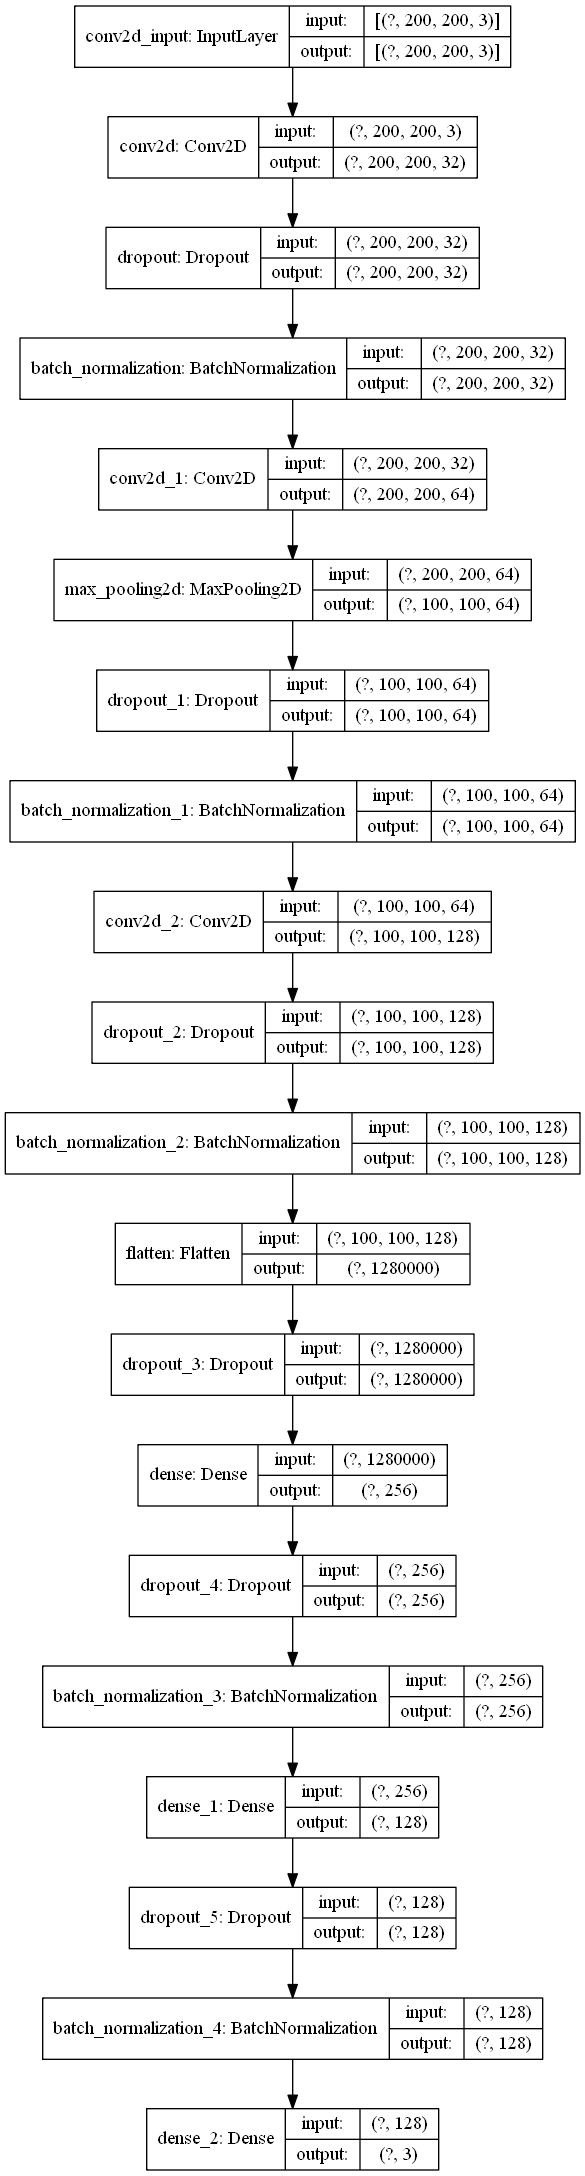

In [44]:
model = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [45]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_sequential_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)

Epoch 1/25
60/60 [==============================] - 2551s 43s/step - loss: 0.5444 - accuracy: 0.8166 - val_loss: 1.2044 - val_accuracy: 0.8698
Epoch 2/25
60/60 [==============================] - 2877s 48s/step - loss: 0.3103 - accuracy: 0.8917 - val_loss: 1.2755 - val_accuracy: 0.8698
Epoch 3/25
60/60 [==============================] - 2332s 39s/step - loss: 0.2626 - accuracy: 0.9086 - val_loss: 0.5721 - val_accuracy: 0.8698
Epoch 4/25
 8/60 [===>..........................] - ETA: 44:03:14 - loss: 0.2774 - accuracy: 0.8954

KeyboardInterrupt: 

In [9]:
reload_model = 'model_sequential_checkpoint_10.h5'
recon_model = keras.models.load_model(os.path.join(modelpath,reload_model))

In [ ]:
print(model.summary())

In [14]:
cnn_eval=recon_model.evaluate(validation_generator)

315/315 [==============================] - 63s 201ms/step - loss: 0.4449 - accuracy: 0.8698


In [18]:
validation_generator.reset()
pred = recon_model.predict(validation_generator, verbose=1)
#results = pred_results(train_generator, test_generator, pred, 'cnn_model_results')

315/315 [==============================] - 67s 213ms/step


In [23]:
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(validation_generator.classes, predicted_classes)
#classification_report(validation_generator.classes, predicted_classes, target_names=os.listdir(train))

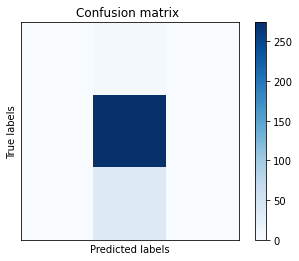

In [34]:
plot_confusion_matrix(cm)

# WEIGHTED CNN MODEL

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.labels), train_generator.labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
wmodel = sequential_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(wmodel, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_sequentialweighted_checkpoint_{epochs}.h5')),]

wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

wmodel.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          class_weight=class_weights)



In [25]:
reload_model = 'model_sequentialweighted_checkpoint_10.h5'
recon_model = keras.models.load_model(os.path.join(modelpath,reload_model))

In [ ]:
print(wmodel.summary())

In [26]:
recon_model.evaluate(validation_generator)

315/315 [==============================] - 64s 202ms/step - loss: 0.6445 - accuracy: 0.8698


[0.6445108652114868, 0.8698412775993347]

In [ ]:
validation_generator.reset()
pred = wmodel.predict(validation_generator, verbose=1)
#pred_results(train_generator, test_generator, pred, 'cnn_model_weighted_results')

In [28]:
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(validation_generator.classes, predicted_classes)
#classification_report(validation_generator.classes, predicted_classes, target_names=list(df.label.unique()))

In [ ]:
plot_confusion_matrix(cm)

# RESNET50 MODEL

In [ ]:
resnet50model = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
keras.utils.plot_model(resnet50model, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

resnet50model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

In [ ]:
resnet50model.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          batch_size=batch_size)

print(resnet50model.summary())

In [ ]:
reconstructed_model = keras.models.load_model(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5'))
resnet50model = reconstructed_model

In [ ]:
resnet50model.evaluate(validation_generator)

In [ ]:
validation_generator.reset() #test_generator.reset()
rn50pred = resnet50model.predict(validation_generator, verbose=1) #test_generator, verbose=1)

In [ ]:
rn50predicted_class_indices=np.argmax(rn50pred,axis=1)

In [ ]:
rn50labels = (train_generator.class_indices)
rn50labels = dict((v,k) for k,v in rn50labels.items())
resnet50predictions = [rn50labels[k] for k in rn50predicted_class_indices]
rn50truelabels = [rn50labels[k] for k in validation_generator.labels]

In [ ]:
rn50filenames=validation_generator.filenames #test_generator.filenames
resnet50results=pd.DataFrame({"Filename":rn50filenames,
                              "True_Label":rn50truelabels,
                      "Predictions":resnet50predictions})
#results.to_csv("results_resnet50.csv",index=False)

In [ ]:
confusion_matrix(validation_generator.classes, rn50predicted_class_indices)
classification_report(validation_generator.classes, rn50predicted_class_indices, target_names=list(df.label.unique()))

# RESNET50 WEIGHTED MODEL

In [ ]:
r50wmodel = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
#keras.utils.plot_model(r50wmodel, show_shapes=True)

In [ ]:
#this uses class weights
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50weighted_checkpoint_{epochs}.h5')),]

r50wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']#, 'precision', 'recall'],
                 )

r50wmodel.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          class_weight=class_weights)#try train_data, train_labels from train_generator?

print(r50wmodel.summary())

In [ ]:
validation_generator.reset()#test_generator.reset()
#pred = model.predict(test_generator, verbose=1)
pred = r50wmodel.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
true_labels = [labels[k] for k in validation_generator.labels]
filenames=validation_generator.filenames#test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "True_Label":true_labels,
                      "Predictions":predictions})
#results.to_csv("seq_results.csv",index=False)

In [ ]:
confusion_matrix(validation_generator.classes, predicted_class_indices)
classification_report(validation_generator.classes, predicted_class_indices, target_names=list(df.label.unique()))